### References:
* https://www.kaggle.com/code/matanivanov/wide-deep-learning-for-recsys-with-pytorch
* https://wngaw.github.io/wide-and-deep-learning/
* https://happystrongcoder.substack.com/p/wide-and-deep-learning-for-recommender


In [78]:
import pandas as pd

from torch import nn, cat, mean
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")


In [57]:
# Column headers for the dataset
data_cols = ['user id', 'movie id', 'rating', 'timestamp']
item_cols = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action',
             'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
             'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War', 'Western']
user_cols = ['user id', 'age', 'gender', 'occupation', 'zip code']

In [58]:
users = pd.read_csv('./ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')
item = pd.read_csv('./ml-100k/u.item', sep='|', names=item_cols, encoding='latin-1')
data = pd.read_csv('./ml-100k/u.data', sep='\t', names=data_cols, encoding='latin-1')
genres = pd.read_csv('./ml-100k/u.genre', sep='|', header=None, usecols=[0])[0].tolist()


In [59]:
genres

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [11]:
users.shape, users.head()

((943, 5),
    user id  age gender  occupation zip code
 0        1   24      M  technician    85711
 1        2   53      F       other    94043
 2        3   23      M      writer    32067
 3        4   24      M  technician    43537
 4        5   33      F       other    15213)

In [16]:
item.shape

(1682, 24)

In [15]:
item.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
data.shape, data.head()

((100000, 4),
    user id  movie id  rating  timestamp
 0      196       242       3  881250949
 1      186       302       3  891717742
 2       22       377       1  878887116
 3      244        51       2  880606923
 4      166       346       1  886397596)

<Axes: xlabel='rating'>

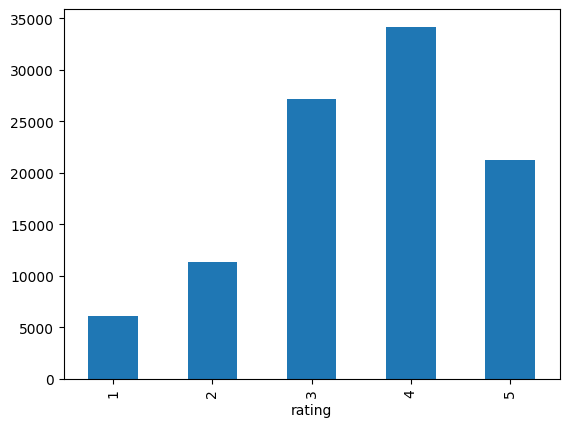

In [64]:
data.rating.value_counts().sort_index().plot.bar()

<Axes: xlabel='gender'>

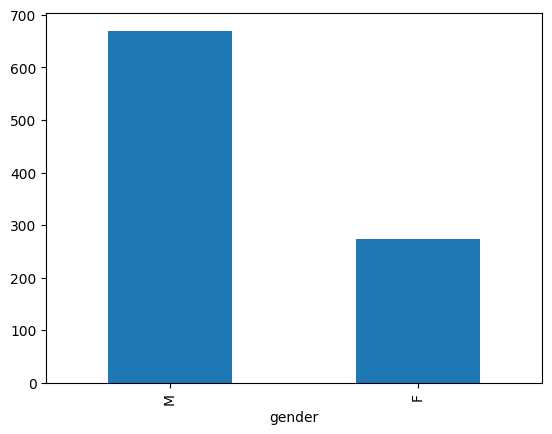

In [65]:
users.gender.value_counts().plot.bar()

<Axes: xlabel='occupation'>

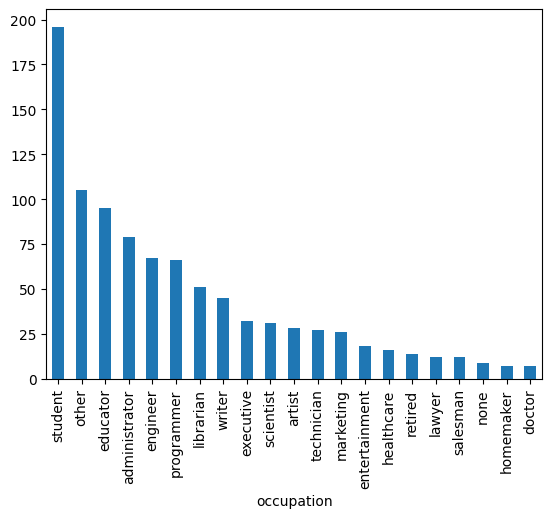

In [67]:
users.occupation.value_counts().plot.bar()

In [18]:
final_df = pd.merge(pd.merge(item,data), users)

In [19]:
final_df.shape

(100000, 31)

In [20]:
final_df.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Thriller,War,Western,user id,rating,timestamp,age,gender,occupation,zip code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,308,5,887736696,60,M,retired,95076


In [79]:
df_wide = final_df[['gender','occupation']]

In [80]:
df_wide['gender_occupation'] = df_wide['gender'] + "_" + df_wide['occupation']
# Cross product feature step 1

In [81]:
df_wide.occupation.value_counts()

occupation
student          21957
other            10663
educator          9442
engineer          8175
programmer        7801
administrator     7479
writer            5536
librarian         5273
technician        3506
executive         3403
healthcare        2804
artist            2308
entertainment     2095
scientist         2058
marketing         1950
retired           1609
lawyer            1345
none               901
salesman           856
doctor             540
homemaker          299
Name: count, dtype: int64

In [83]:
# Cross product feature step 2
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_wide[['gender_occupation']])

one_hot_encoded_df = pd.DataFrame(encoder.transform(df_wide[['gender_occupation']]).toarray(),
                                  columns=encoder.get_feature_names_out())

In [84]:
one_hot_encoded_df

,gender_occupation_F_administrator,gender_occupation_F_artist,gender_occupation_F_educator,gender_occupation_F_engineer,gender_occupation_F_entertainment,gender_occupation_F_executive,gender_occupation_F_healthcare,gender_occupation_F_homemaker,gender_occupation_F_lawyer,gender_occupation_F_librarian,...,gender_occupation_M_marketing,gender_occupation_M_none,gender_occupation_M_other,gender_occupation_M_programmer,gender_occupation_M_retired,gender_occupation_M_salesman,gender_occupation_M_scientist,gender_occupation_M_student,gender_occupation_M_technician,gender_occupation_M_writer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [85]:
df_wide = df_wide.join(one_hot_encoded_df)
df_wide.drop(['gender','occupation','gender_occupation'],axis=1, inplace=True)

In [86]:
df_wide

,gender_occupation_F_administrator,gender_occupation_F_artist,gender_occupation_F_educator,gender_occupation_F_engineer,gender_occupation_F_entertainment,gender_occupation_F_executive,gender_occupation_F_healthcare,gender_occupation_F_homemaker,gender_occupation_F_lawyer,gender_occupation_F_librarian,...,gender_occupation_M_marketing,gender_occupation_M_none,gender_occupation_M_other,gender_occupation_M_programmer,gender_occupation_M_retired,gender_occupation_M_salesman,gender_occupation_M_scientist,gender_occupation_M_student,gender_occupation_M_technician,gender_occupation_M_writer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [87]:
df_deep = final_df[['age', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
              'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War',
              'Western', 'gender', 'occupation']]

In [88]:
# Combine sparse categorical features into one single genre feature
df_deep['genre'] =  df_deep[['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
                            'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi',
                            'Thriller', 'War', 'Western']].idxmax(1)

In [89]:
df_deep['genre']

0        Animation
1           Action
2            Crime
3            Drama
4        Childrens
           ...    
99995       Action
99996       Action
99997       Action
99998    Childrens
99999       Comedy
Name: genre, Length: 100000, dtype: object

In [90]:
df_deep.drop(columns=['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
                      'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller',
                      'War', 'Western'], axis=1, inplace=True)

In [91]:
# Encode categorical features

for feature in ['gender','occupation','genre']:
    encoder = LabelEncoder()
    encoder.fit(df_deep[[feature]])
    transfromed_feature = encoder.transform(df_deep[[feature]])
    df_deep[feature]=transfromed_feature

In [92]:
# Min-max scaling for numerical features
for feature in ['age']:
    scaler = MinMaxScaler()
    scaler.fit(df_deep[[feature]])
    transformed_feature = scaler.transform(df_deep[[feature]])
    df_deep[feature] = transformed_feature

In [93]:
df_deep.head()

,age,gender,occupation,genre
0,0.80303,1,15,2
1,0.80303,1,15,0
2,0.80303,1,15,5
3,0.80303,1,15,7
4,0.80303,1,15,3


In [94]:
X = pd.concat([df_wide, df_deep], axis=1)
y=final_df['rating']

In [95]:
X.head()

,gender_occupation_F_administrator,gender_occupation_F_artist,gender_occupation_F_educator,gender_occupation_F_engineer,gender_occupation_F_entertainment,gender_occupation_F_executive,gender_occupation_F_healthcare,gender_occupation_F_homemaker,gender_occupation_F_lawyer,gender_occupation_F_librarian,...,gender_occupation_M_retired,gender_occupation_M_salesman,gender_occupation_M_scientist,gender_occupation_M_student,gender_occupation_M_technician,gender_occupation_M_writer,age,gender,occupation,genre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.80303,1,15,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.80303,1,15,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.80303,1,15,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.80303,1,15,7
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.80303,1,15,3


In [96]:
y.head()

0    4
1    5
2    4
3    4
4    5
Name: rating, dtype: int64

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=100)

In [102]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [145]:
X_train.head()

,gender_occupation_F_administrator,gender_occupation_F_artist,gender_occupation_F_educator,gender_occupation_F_engineer,gender_occupation_F_entertainment,gender_occupation_F_executive,gender_occupation_F_healthcare,gender_occupation_F_homemaker,gender_occupation_F_lawyer,gender_occupation_F_librarian,...,gender_occupation_M_retired,gender_occupation_M_salesman,gender_occupation_M_scientist,gender_occupation_M_student,gender_occupation_M_technician,gender_occupation_M_writer,age,gender,occupation,genre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0,13,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.287879,1,6,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.651515,0,7,7
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.257576,1,4,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.696970,1,9,7


In [106]:
df_wide.columns

Index(['gender_occupation_F_administrator', 'gender_occupation_F_artist',
       'gender_occupation_F_educator', 'gender_occupation_F_engineer',
       'gender_occupation_F_entertainment', 'gender_occupation_F_executive',
       'gender_occupation_F_healthcare', 'gender_occupation_F_homemaker',
       'gender_occupation_F_lawyer', 'gender_occupation_F_librarian',
       'gender_occupation_F_marketing', 'gender_occupation_F_none',
       'gender_occupation_F_other', 'gender_occupation_F_programmer',
       'gender_occupation_F_retired', 'gender_occupation_F_salesman',
       'gender_occupation_F_scientist', 'gender_occupation_F_student',
       'gender_occupation_F_technician', 'gender_occupation_F_writer',
       'gender_occupation_M_administrator', 'gender_occupation_M_artist',
       'gender_occupation_M_doctor', 'gender_occupation_M_educator',
       'gender_occupation_M_engineer', 'gender_occupation_M_entertainment',
       'gender_occupation_M_executive', 'gender_occupation_M_heal

In [112]:
def prepare_independent_variables(X):
    """Split X dataframe into its separate input components for the neural network.
    
    # prepare wide_inputs for wide model
    +
    prepare categorical_input_gender, categorical_input_occupation, categorical_input_genre, numerical_input_age for deep model
    
    """

    wide_inputs = X[['gender_occupation_F_administrator', 'gender_occupation_F_artist',
       'gender_occupation_F_educator', 'gender_occupation_F_engineer',
       'gender_occupation_F_entertainment', 'gender_occupation_F_executive',
       'gender_occupation_F_healthcare', 'gender_occupation_F_homemaker',
       'gender_occupation_F_lawyer', 'gender_occupation_F_librarian',
       'gender_occupation_F_marketing', 'gender_occupation_F_none',
       'gender_occupation_F_other', 'gender_occupation_F_programmer',
       'gender_occupation_F_retired', 'gender_occupation_F_salesman',
       'gender_occupation_F_scientist', 'gender_occupation_F_student',
       'gender_occupation_F_technician', 'gender_occupation_F_writer',
       'gender_occupation_M_administrator', 'gender_occupation_M_artist',
       'gender_occupation_M_doctor', 'gender_occupation_M_educator',
       'gender_occupation_M_engineer', 'gender_occupation_M_entertainment',
       'gender_occupation_M_executive', 'gender_occupation_M_healthcare',
       'gender_occupation_M_homemaker', 'gender_occupation_M_lawyer',
       'gender_occupation_M_librarian', 'gender_occupation_M_marketing',
       'gender_occupation_M_none', 'gender_occupation_M_other',
       'gender_occupation_M_programmer', 'gender_occupation_M_retired',
       'gender_occupation_M_salesman', 'gender_occupation_M_scientist',
       'gender_occupation_M_student', 'gender_occupation_M_technician',
       'gender_occupation_M_writer']].values
    
    categorical_input_gender = X[['gender']].values
    categorical_input_occupation = X[['occupation']].values
    categorical_input_genre = X[['genre']].values
    numerical_inputs = X[['age']].values
    
    return wide_inputs, categorical_input_gender, categorical_input_occupation, categorical_input_genre, numerical_inputs


In [113]:

wide_inputs_train, categorical_input_gender_train, categorical_input_occupation_train, \
categorical_input_genre_train, numerical_inputs_train = prepare_independent_variables(X_train)

wide_inputs_test, categorical_input_gender_test, categorical_input_occupation_test, \
categorical_input_genre_test, numerical_inputs_test = prepare_independent_variables(X_test)



In [135]:
train_dataset = list(zip(wide_inputs_train, categorical_input_gender_train, categorical_input_occupation_train, \
categorical_input_genre_train, numerical_inputs_train, y_train))


test_dataset = list(zip(wide_inputs_test, categorical_input_gender_test, categorical_input_occupation_test, \
categorical_input_genre_test, numerical_inputs_test))

In [138]:
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [121]:
categorical_input_gender_train

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [122]:
wide_inputs_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [123]:
# Define the model 

In [392]:
class MyWideAndDeepRecModel(nn.Module):
    # do we need different vocab_size for each categorical feature ?
    def __init__(self,continious_feature_shape,vocab_size_gender,vocab_size_occupation,vocab_size_genre, embed_dim, wide_inputs_shape):
        super(MyWideAndDeepRecModel,self).__init__()
        
        self.embedding_gender = nn.Embedding(vocab_size_gender, embed_dim,sparse=False)
        # self.flatten_gender = nn.Flatten()
        
        self.embedding_occupation = nn.Embedding(vocab_size_occupation, embed_dim,sparse=False)
        # self.flatten_occupation = nn.Flatten()
        
        self.embedding_genre = nn.Embedding(vocab_size_genre, embed_dim,sparse=False)
        # self.flatten_genre = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear( embed_dim*3 + continious_feature_shape, 512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU()
        )
        
        self.head = nn.Sequential (
            nn.Linear(128+wide_inputs_shape, embed_dim),
            nn.Linear(embed_dim,5)
            )
    
    def forward(self, continous, gender, occupation, genre, wide_inputs):
        embed1 = mean(self.embedding_gender(gender), dim=1)
        embed2 = mean(self.embedding_occupation(occupation), dim=1)
        embed3 = mean(self.embedding_genre(genre), dim=1)
        
        self.deep_logits = self.linear_relu_stack(cat((embed1,embed2,embed3,continous), dim=1))
        self.final_rating_class = self.head(cat((self.deep_logits, wide_inputs),dim=1))
        # self.total_logits = nn.Linear(297, embed_dim)()
        return self.final_rating_class

In [393]:
256+43

299

In [394]:
X_train.shape

(75000, 45)

In [395]:
mymodel = MyWideAndDeepRecModel(
    continious_feature_shape=1,
    vocab_size_gender=2,
    vocab_size_occupation=21,
    vocab_size_genre=19, 
    wide_inputs_shape=41,
    embed_dim=64
)

In [396]:
mymodel

MyWideAndDeepRecModel(
  (embedding_gender): Embedding(2, 64)
  (embedding_occupation): Embedding(21, 64)
  (embedding_genre): Embedding(19, 64)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=193, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=169, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [399]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mymodel.parameters(), lr=1e-2)

# criterion = nn.CrossEntropyLoss() ## This will apply softmax for us
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [461]:
for epoch in range(20):
    mymodel.train()
    pred_train = mymodel(torch.tensor(numerical_inputs_train, dtype=torch.int),
                      torch.tensor(categorical_input_gender_train,dtype=torch.int),
                      torch.tensor(categorical_input_occupation_train,dtype=torch.int),
                      torch.tensor(categorical_input_genre_train,dtype=torch.int), 
                      torch.tensor(wide_inputs_train,dtype=torch.int))
    loss = criterion(pred_train,torch.tensor(y_train-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

1.4524531364440918
1.4516119956970215
1.450585961341858
1.4496040344238281
1.4487709999084473
1.4479314088821411
1.447015643119812
1.4464048147201538
1.4454509019851685
1.4445308446884155
1.4438475370407104
1.4431428909301758
1.442574143409729
1.442171335220337
1.44176185131073
1.4413315057754517
1.4409544467926025
1.4405617713928223
1.4401065111160278
1.4397940635681152


In [462]:
pred_train = mymodel(torch.tensor(numerical_inputs_train, dtype=torch.int),
                      torch.tensor(categorical_input_gender_train,dtype=torch.int),
                      torch.tensor(categorical_input_occupation_train,dtype=torch.int),
                      torch.tensor(categorical_input_genre_train,dtype=torch.int), 
                      torch.tensor(wide_inputs_train,dtype=torch.int))

In [463]:
 _,predictions= torch.max(pred_train,1)

In [464]:
predictions.min(), predictions.max()

(tensor(2), tensor(4))

In [465]:
pd.DataFrame(predictions.numpy())[0].value_counts()

0
3    61844
2    11389
4     1767
Name: count, dtype: int64

In [466]:
(y_train-1).value_counts()

rating
3    25630
2    20359
4    15901
1     8528
0     4582
Name: count, dtype: int64

In [467]:
criterion(pred_train,torch.tensor(y_train-1))

tensor(1.4396, grad_fn=<NllLossBackward0>)

In [468]:
predictions[0:4]

tensor([3, 3, 2, 3])

In [469]:
y_train_actual = y_train-1

In [470]:
(y_train_actual==predictions.numpy()).sum()

26138

In [471]:
y_train.shape

(75000,)

In [472]:
(y_train_actual==predictions.numpy()).sum()/y_train.shape[0]

0.3485066666666667